# 🎬 Movie Knowledge Graph - Interactive Exploration

This notebook provides a hands-on exploration of knowledge graphs using both **RDF/SPARQL** and **Neo4j/Cypher** approaches.

## Objectives
1. Compare RDF vs Property Graph models
2. Execute and understand queries interactively
3. Visualize graph structures
4. Analyze movie relationships
5. Build simple recommendation systems

---

## Table of Contents
1. [Setup & Imports](#1-setup--imports)
2. [Data Loading & Overview](#2-data-loading--overview)
3. [Building Knowledge Graphs](#3-building-knowledge-graphs)
4. [Query Comparison: SPARQL vs Cypher](#4-query-comparison)
5. [Genre Analysis & Visualization](#5-genre-analysis)
6. [Director Analysis](#6-director-analysis)
7. [Graph Visualization](#7-graph-visualization)
8. [Movie Recommendations](#8-movie-recommendations)
9. [Advanced Analytics](#9-advanced-analytics)
10. [Cleanup](#10-cleanup)

## 1. Setup & Imports

First, let's import all the necessary libraries and configure our environment.

In [4]:
# Standard library imports
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src directory to path for local imports
sys.path.append('../src')
sys.path.append('..')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Configure plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_palette("husl")

print("Standard libraries imported successfully!")

Standard libraries imported successfully!


In [3]:
# Import our custom modules
try:
    from src.rdf_builder import MovieRDFBuilder
    from src.neo4j_loader import MovieNeo4jLoader
    from src.analytics import MovieAnalytics
    from queries.sparql_examples import MovieSPARQLQueries
    from queries.cypher_examples import MovieCypherQueries
    print("Custom modules imported successfully!")
except ImportError as e:
    print(f"Import error: {e}")
    print("Make sure you're running this notebook from the 'notebooks/' directory")

Custom modules imported successfully!


---

## 2. Data Loading & Overview

Let's start by exploring our raw movie dataset to understand what we're working with.

In [5]:
# Load the raw movie data
df = pd.read_csv('../data/raw/movies.csv')

print("Dataset Overview")
print("=" * 40)
print(f"   Total Movies: {len(df)}")
print(f"   Unique Directors: {df['director'].nunique()}")
print(f"   Year Range: {df['year'].min()} - {df['year'].max()}")
print(f"   Rating Range: {df['rating'].min()} - {df['rating'].max()}")
print("\nColumns:", list(df.columns))

Dataset Overview
   Total Movies: 7
   Unique Directors: 5
   Year Range: 1994 - 2014
   Rating Range: 8.6 - 9.0

Columns: ['movie_id', 'title', 'year', 'genres', 'director', 'rating']


In [6]:
# Display the full dataset - it's small enough to see everything
print("Complete Movie Dataset:")
df

Complete Movie Dataset:


,movie_id,title,year,genres,director,rating
0,1,The Matrix,1999,Action|Sci-Fi,Lana Wachowski,8.7
1,2,Inception,2010,Action|Sci-Fi|Thriller,Christopher Nolan,8.8
2,3,Interstellar,2014,Drama|Sci-Fi,Christopher Nolan,8.6
3,4,Pulp Fiction,1994,Crime|Drama,Quentin Tarantino,8.9
4,5,The Dark Knight,2008,Action|Crime|Drama,Christopher Nolan,9.0
5,6,Forrest Gump,1994,Drama|Romance,Robert Zemeckis,8.8
6,7,Fight Club,1999,Drama,David Fincher,8.8


In [7]:
# Statistical summary
print("Statistical Summary:")
df.describe()

Statistical Summary:


,movie_id,year,rating
count,7.000000,7.000000,7.000000
mean,4.000000,2002.571429,8.800000
std,2.160247,8.038597,0.129099
min,1.000000,1994.000000,8.600000
25%,2.500000,1996.500000,8.750000
50%,4.000000,1999.000000,8.800000
75%,5.500000,2009.000000,8.850000
max,7.000000,2014.000000,9.000000


---

## 3. Building Knowledge Graphs

Now let's transform this tabular data into knowledge graphs using two different approaches:

### 3.1 RDF Knowledge Graph (Semantic Web Approach)

RDF represents knowledge as **triples**: `Subject → Predicate → Object`

```
(The Matrix) → [directedBy] → (Lana Wachowski)
(The Matrix) → [hasGenre]   → (Sci-Fi)
(The Matrix) → [hasRating]  → "8.7"
```

In [8]:
# Build RDF Knowledge Graph
print("Building RDF Knowledge Graph...")
print("=" * 40)

rdf_builder = MovieRDFBuilder()
rdf_builder.load_from_csv('../data/raw/movies.csv')

# Get statistics
rdf_stats = rdf_builder.get_statistics()
print("\nRDF Graph Statistics:")
for key, value in rdf_stats.items():
    print(f"   • {key}: {value}")

INFO:src.rdf_builder:Ontology created with 5 classes and 6 properties
INFO:src.rdf_builder:MovieRDFBuilder initialized
INFO:src.rdf_builder:Loading 7 movies from ../data/raw/movies.csv
INFO:src.rdf_builder:Added movie: The Matrix (1999)
INFO:src.rdf_builder:Added movie: Inception (2010)
INFO:src.rdf_builder:Added movie: Interstellar (2014)
INFO:src.rdf_builder:Added movie: Pulp Fiction (1994)
INFO:src.rdf_builder:Added movie: The Dark Knight (2008)
INFO:src.rdf_builder:Added movie: Forrest Gump (1994)
INFO:src.rdf_builder:Added movie: Fight Club (1999)
INFO:src.rdf_builder:Successfully loaded 7 movies. Graph now has 94 triples.


Building RDF Knowledge Graph...

RDF Graph Statistics:
   • movies: 7
   • directors: 0
   • genres: 0
   • total_triples: 94


### 3.2 Neo4j Property Graph (Graph Database Approach)

Neo4j uses **nodes** and **relationships** with **properties**:

```
(:Movie {title: "Inception", year: 2010})-[:DIRECTED_BY]->(:Director {name: "Christopher Nolan"})
```

> **Note**: Make sure Neo4j is running! Start it with:
> ```bash
> podman run -d --name movie-neo4j -p 7474:7474 -p 7687:7687 -e NEO4J_AUTH=neo4j/password neo4j:latest
> ```

In [9]:
# Build Neo4j Property Graph
# Set neo4j_available to False if Neo4j is not running
neo4j_available = False
neo4j_loader = None

try:
    print("Building Neo4j Property Graph...")
    print("=" * 40)
    
    neo4j_loader = MovieNeo4jLoader()
    neo4j_loader.clear_database()  # Start fresh
    neo4j_loader.load_from_csv('../data/raw/movies.csv')
    
    # Get statistics
    neo4j_stats = neo4j_loader.get_statistics()
    print("\nNeo4j Graph Statistics:")
    for key, value in neo4j_stats.items():
        print(f"   • {key}: {value}")
    
    neo4j_available = True
    print("\nNeo4j connection successful!")
    
except Exception as e:
    print(f"Neo4j not available: {e}")
    print("   Continuing with RDF-only analysis...")
    print("   To enable Neo4j, run: podman run -d --name movie-neo4j -p 7474:7474 -p 7687:7687 -e NEO4J_AUTH=neo4j/password neo4j:latest")

Building Neo4j Property Graph...


ERROR:src.neo4j_loader:Failed to connect to Neo4j: Couldn't connect to localhost:7687 (resolved to ('127.0.0.1:7687', '[::1]:7687')):
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [WinError 10061] No connection could be made because the target machine actively refused it)
Failed to establish connection to ResolvedIPv6Address(('::1', 7687, 0, 0)) (reason [WinError 10061] No connection could be made because the target machine actively refused it)


Neo4j not available: Couldn't connect to localhost:7687 (resolved to ('127.0.0.1:7687', '[::1]:7687')):
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [WinError 10061] No connection could be made because the target machine actively refused it)
Failed to establish connection to ResolvedIPv6Address(('::1', 7687, 0, 0)) (reason [WinError 10061] No connection could be made because the target machine actively refused it)
   Continuing with RDF-only analysis...
   To enable Neo4j, run: podman run -d --name movie-neo4j -p 7474:7474 -p 7687:7687 -e NEO4J_AUTH=neo4j/password neo4j:latest


---

## 4. Query Comparison: SPARQL vs Cypher

Let's compare how the same queries look in both query languages. This is one of the most important learning outcomes of this project!

### 4.1 Find All Movies with Directors

In [10]:
# Initialize query engines
sparql_queries = MovieSPARQLQueries(rdf_builder.graph)

if neo4j_available:
    cypher_queries = MovieCypherQueries(neo4j_loader.driver)

print("SPARQL Query (RDF):")
print("-" * 50)
sparql_example = """
PREFIX movie: <http://movie-kg.org/ontology#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>

SELECT ?title ?year ?rating ?director_name
WHERE {
    ?movie a movie:Movie .
    ?movie movie:hasTitle ?title .
    ?movie movie:releasedIn ?year .
    ?movie movie:hasRating ?rating .
    ?movie movie:directedBy ?director .
    ?director foaf:name ?director_name .
}
ORDER BY ?year
"""
print(sparql_example)

SPARQL Query (RDF):
--------------------------------------------------

PREFIX movie: <http://movie-kg.org/ontology#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>

SELECT ?title ?year ?rating ?director_name
WHERE {
    ?movie a movie:Movie .
    ?movie movie:hasTitle ?title .
    ?movie movie:releasedIn ?year .
    ?movie movie:hasRating ?rating .
    ?movie movie:directedBy ?director .
    ?director foaf:name ?director_name .
}
ORDER BY ?year



In [11]:
# Execute SPARQL query
print("SPARQL Results:")
sparql_movies = sparql_queries.find_all_movies()
sparql_df = pd.DataFrame(sparql_movies)
sparql_df

SPARQL Results:


,title,year,rating,director_name
0,Pulp Fiction,1994,8.9,Quentin Tarantino
1,Forrest Gump,1994,8.8,Robert Zemeckis
2,The Matrix,1999,8.7,Lana Wachowski
3,Fight Club,1999,8.8,David Fincher
4,The Dark Knight,2008,9.0,Christopher Nolan
5,Inception,2010,8.8,Christopher Nolan
6,Interstellar,2014,8.6,Christopher Nolan


In [14]:
# Compare with Cypher (if Neo4j is available)
print("Cypher Query (Neo4j):")
print("-" * 50)
cypher_example = """
MATCH (m:Movie)-[:DIRECTED_BY]->(d:Director)
RETURN m.title as title, m.year as year, 
       m.rating as rating, d.name as director
ORDER BY m.year
"""
print(cypher_example)

if neo4j_available:
    print("\nCypher Results:")
    cypher_movies = cypher_queries.find_all_movies()
    cypher_df = pd.DataFrame(cypher_movies)
    display(cypher_df)
else:
    print("\nNeo4j not available - skipping Cypher execution")

Cypher Query (Neo4j):
--------------------------------------------------

MATCH (m:Movie)-[:DIRECTED_BY]->(d:Director)
RETURN m.title as title, m.year as year, 
       m.rating as rating, d.name as director
ORDER BY m.year


Neo4j not available - skipping Cypher execution


### Key Observations: SPARQL vs Cypher

| Aspect | SPARQL | Cypher |
|--------|--------|--------|
| **Syntax** | More verbose, pattern-based | Concise, ASCII-art style |
| **Namespaces** | Required (PREFIX declarations) | Not needed |
| **Relationships** | `?movie movie:directedBy ?director` | `(m)-[:DIRECTED_BY]->(d)` |
| **Properties** | Triple patterns | Dot notation `m.title` |
| **Learning Curve** | Steeper | More intuitive |

---

## 5. Genre Analysis & Visualization

Let's analyze how movies are distributed across genres.

In [15]:
# Extract and count all genres
all_genres = []
for genres_str in df['genres']:
    if pd.notna(genres_str):
        all_genres.extend(genres_str.split('|'))

genre_counts = pd.Series(all_genres).value_counts()

print("Genre Distribution:")
print("=" * 30)
for genre, count in genre_counts.items():
    print(f"   {genre}: {count} movies")

print(f"\nTotal unique genres: {len(genre_counts)}")
print(f"Most common: {genre_counts.index[0]} ({genre_counts.iloc[0]} movies)")

Genre Distribution:
   Drama: 5 movies
   Action: 3 movies
   Sci-Fi: 3 movies
   Crime: 2 movies
   Thriller: 1 movies
   Romance: 1 movies

Total unique genres: 6
Most common: Drama (5 movies)


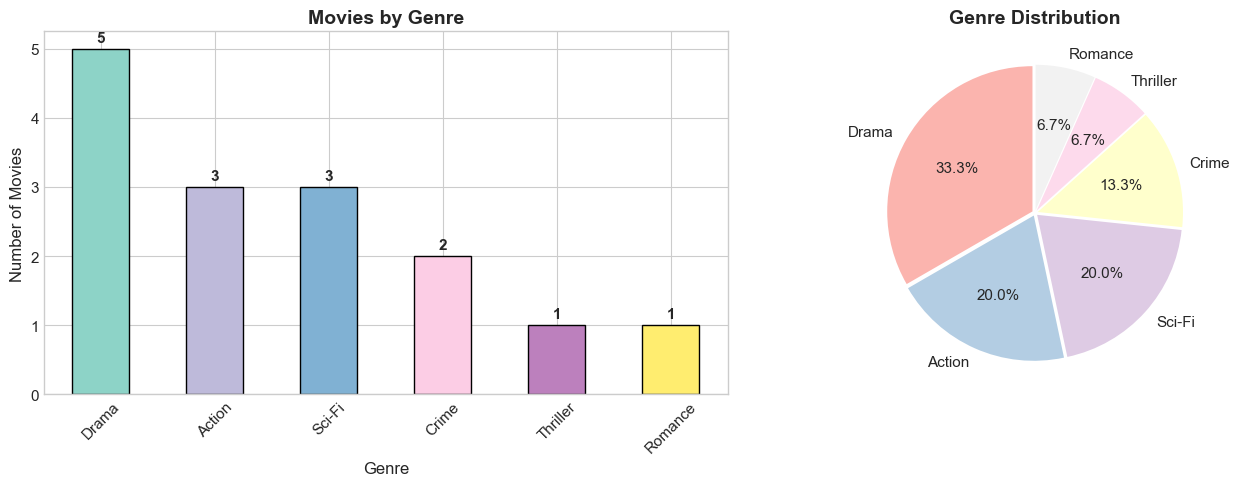

💾 Saved to: output/visualizations/genre_distribution.png


In [ ]:
# Visualize genre distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = plt.cm.Set3(np.linspace(0, 1, len(genre_counts)))
genre_counts.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title('Movies by Genre', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Genre', fontsize=12)
axes[0].set_ylabel('Number of Movies', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(genre_counts.values):
    axes[0].text(i, v + 0.1, str(v), ha='center', fontweight='bold')

# Pie chart
colors_pie = plt.cm.Pastel1(np.linspace(0, 1, len(genre_counts)))
axes[1].pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%', 
            colors=colors_pie, startangle=90, explode=[0.02]*len(genre_counts))
axes[1].set_title('Genre Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../output/visualizations/genre_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved to: output/visualizations/genre_distribution.png")

---

## 6. Director Analysis

Let's analyze directors by their productivity and average ratings.

In [17]:
# Analyze directors
director_stats = df.groupby('director').agg({
    'title': 'count',
    'rating': ['mean', 'max', 'min'],
    'year': ['min', 'max']
}).round(2)

director_stats.columns = ['movie_count', 'avg_rating', 'max_rating', 'min_rating', 'first_year', 'last_year']
director_stats = director_stats.sort_values('movie_count', ascending=False)

print("Director Statistics:")
director_stats

Director Statistics:


,movie_count,avg_rating,max_rating,min_rating,first_year,last_year
director,,,,,,
Christopher Nolan,3,8.8,9.0,8.6,2008,2014
David Fincher,1,8.8,8.8,8.8,1999,1999
Lana Wachowski,1,8.7,8.7,8.7,1999,1999
Quentin Tarantino,1,8.9,8.9,8.9,1994,1994
Robert Zemeckis,1,8.8,8.8,8.8,1994,1994


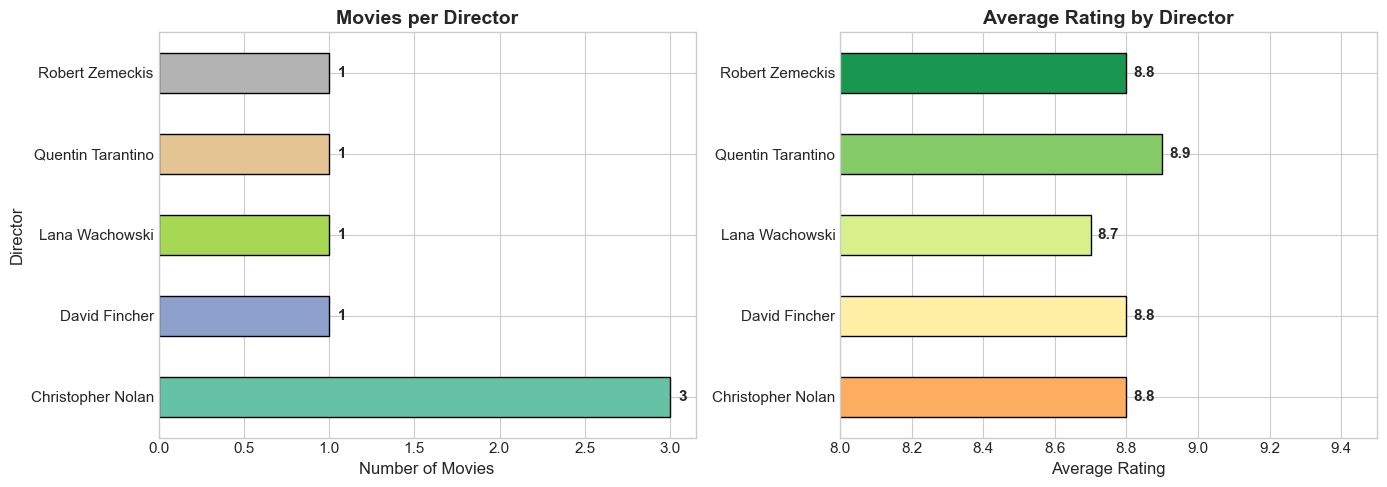

Saved to: output/visualizations/director_analysis.png


In [18]:
# Visualize director analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Movies per director
colors1 = plt.cm.Set2(np.linspace(0, 1, len(director_stats)))
director_stats['movie_count'].plot(kind='barh', ax=axes[0], color=colors1, edgecolor='black')
axes[0].set_title('Movies per Director', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Movies', fontsize=12)
axes[0].set_ylabel('Director', fontsize=12)

# Add value labels
for i, v in enumerate(director_stats['movie_count'].values):
    axes[0].text(v + 0.05, i, str(v), va='center', fontweight='bold')

# Average rating by director
colors2 = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(director_stats)))
director_stats['avg_rating'].plot(kind='barh', ax=axes[1], color=colors2, edgecolor='black')
axes[1].set_title('Average Rating by Director', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Average Rating', fontsize=12)
axes[1].set_ylabel('')
axes[1].set_xlim(8, 9.5)

# Add value labels
for i, v in enumerate(director_stats['avg_rating'].values):
    axes[1].text(v + 0.02, i, f'{v:.1f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../output/visualizations/director_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved to: output/visualizations/director_analysis.png")

---

## 7. Graph Visualization

Now let's visualize our knowledge graph structure using NetworkX. This helps understand how entities are connected.

In [19]:
# Build NetworkX graph for visualization
G = nx.Graph()

# Add nodes and edges from our data
for _, row in df.iterrows():
    movie_title = row['title']
    director_name = row['director']
    
    # Add movie node
    G.add_node(movie_title, node_type='movie', year=row['year'], rating=row['rating'])
    
    # Add director node
    G.add_node(director_name, node_type='director')
    
    # Add directed_by edge
    G.add_edge(movie_title, director_name, relationship='DIRECTED_BY')
    
    # Add genre nodes and edges
    if pd.notna(row['genres']):
        for genre in row['genres'].split('|'):
            G.add_node(genre, node_type='genre')
            G.add_edge(movie_title, genre, relationship='HAS_GENRE')

print("NetworkX Graph Statistics:")
print(f"   • Total Nodes: {G.number_of_nodes()}")
print(f"   • Total Edges: {G.number_of_edges()}")
print(f"   • Movies: {sum(1 for n, d in G.nodes(data=True) if d.get('node_type') == 'movie')}")
print(f"   • Directors: {sum(1 for n, d in G.nodes(data=True) if d.get('node_type') == 'director')}")
print(f"   • Genres: {sum(1 for n, d in G.nodes(data=True) if d.get('node_type') == 'genre')}")

NetworkX Graph Statistics:
   • Total Nodes: 18
   • Total Edges: 22
   • Movies: 7
   • Directors: 5
   • Genres: 6


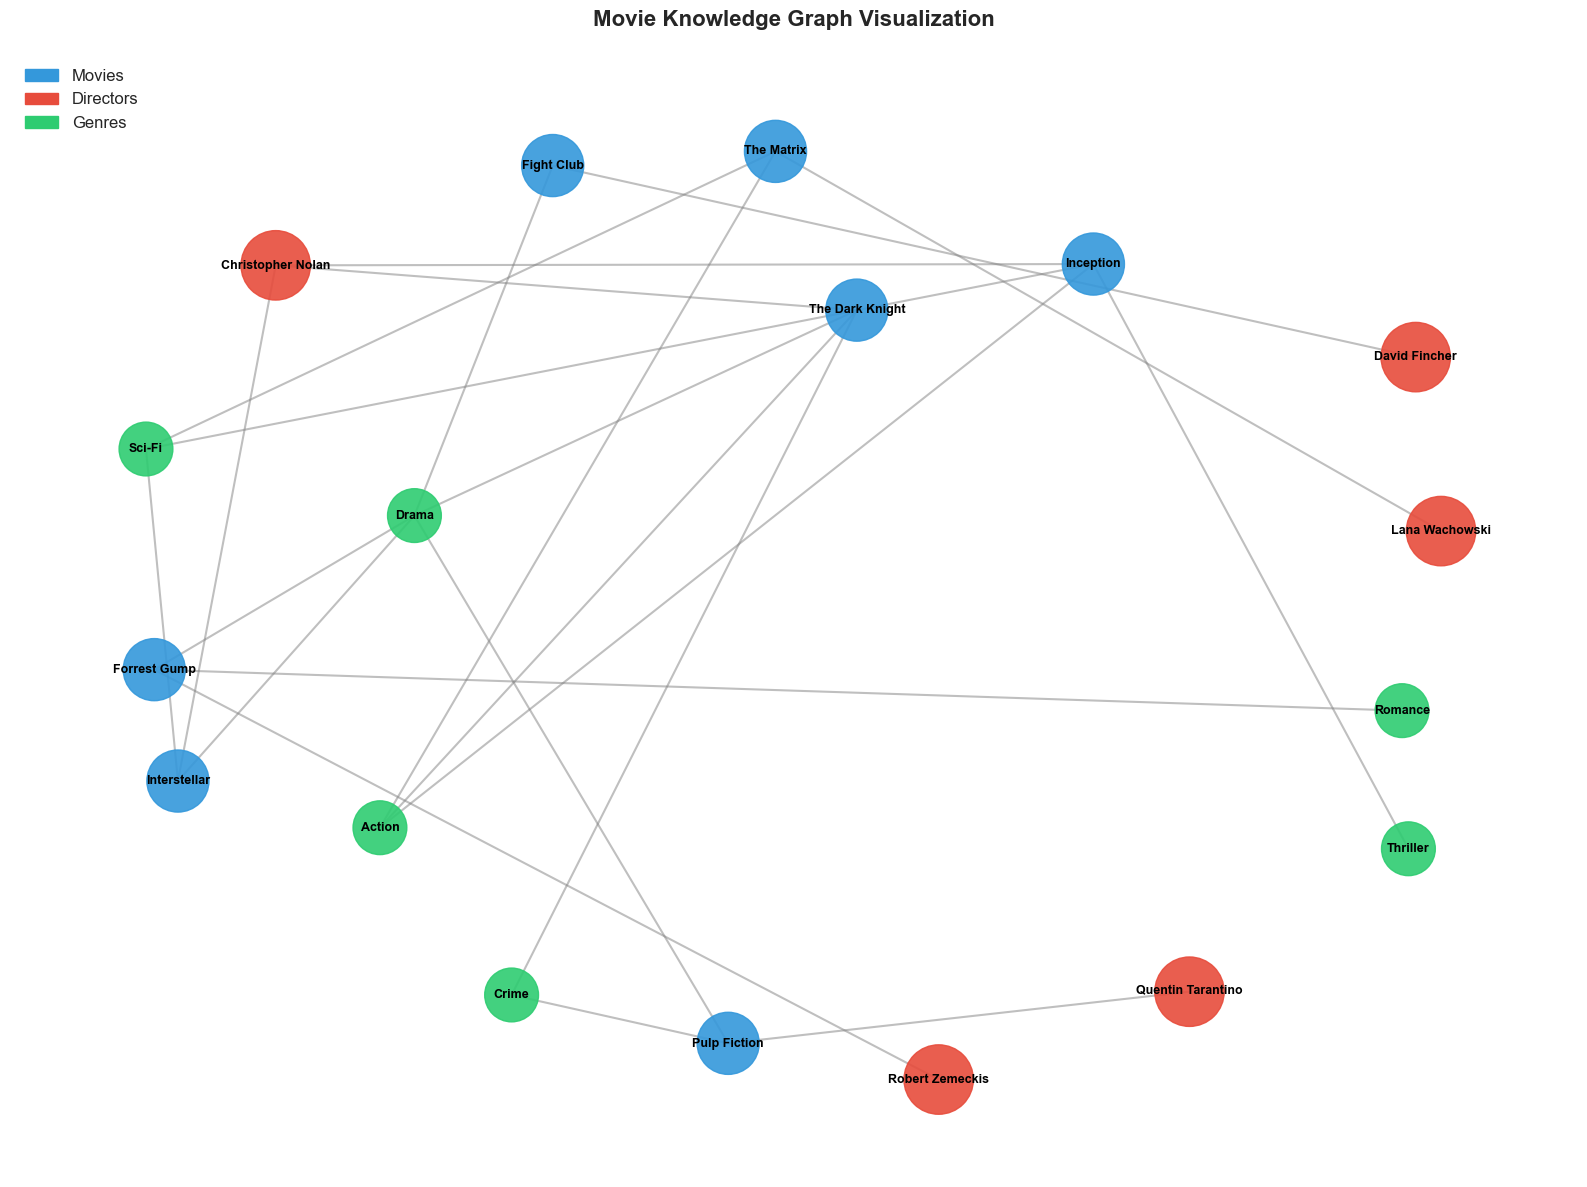

Saved to: output/visualizations/knowledge_graph.png


In [20]:
# Visualize the knowledge graph
plt.figure(figsize=(16, 12))

# Use spring layout for better visualization
pos = nx.spring_layout(G, k=2.5, iterations=50, seed=42)

# Define colors and sizes by node type
node_colors = []
node_sizes = []
for node in G.nodes():
    node_data = G.nodes[node]
    if node_data.get('node_type') == 'movie':
        node_colors.append('#3498db')  # Blue for movies
        node_sizes.append(2000)
    elif node_data.get('node_type') == 'director':
        node_colors.append('#e74c3c')  # Red for directors
        node_sizes.append(2500)
    else:  # Genre
        node_colors.append('#2ecc71')  # Green for genres
        node_sizes.append(1500)

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')

# Add legend
import matplotlib.patches as mpatches
movie_patch = mpatches.Patch(color='#3498db', label='Movies')
director_patch = mpatches.Patch(color='#e74c3c', label='Directors')
genre_patch = mpatches.Patch(color='#2ecc71', label='Genres')
plt.legend(handles=[movie_patch, director_patch, genre_patch], 
           loc='upper left', fontsize=12, framealpha=0.9)

plt.title('Movie Knowledge Graph Visualization', fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('../output/visualizations/knowledge_graph.png', dpi=150, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("Saved to: output/visualizations/knowledge_graph.png")

---

## 8. Movie Recommendations

One of the key applications of knowledge graphs is building recommendation systems. Let's implement a simple genre-based recommender.

In [22]:
def recommend_movies_by_genre(movie_title, df, limit=3):
    """
    Simple recommendation: Find movies with shared genres.
    This demonstrates how knowledge graphs enable recommendations.
    """
    # Get the target movie's genres
    target_row = df[df['title'] == movie_title]
    if target_row.empty:
        return []
    
    target_genres = set(target_row.iloc[0]['genres'].split('|'))
    
    # Find movies with shared genres
    recommendations = []
    for _, row in df.iterrows():
        if row['title'] == movie_title:
            continue
        
        movie_genres = set(row['genres'].split('|'))
        shared = target_genres.intersection(movie_genres)
        
        if shared:
            recommendations.append({
                'title': row['title'],
                'year': row['year'],
                'rating': row['rating'],
                'director': row['director'],
                'shared_genres': list(shared),
                'num_shared': len(shared)
            });
    
    # Sort by number of shared genres, then by rating
    recommendations.sort(key=lambda x: (-x['num_shared'], -x['rating']))
    return recommendations[:limit]

# Test recommendations for different movies
test_movies = ["Inception", "The Matrix", "Pulp Fiction"]

for movie in test_movies:
    print(f"\nMovies similar to '{movie}':")
    print("-" * 50)
    
    recs = recommend_movies_by_genre(movie, df)
    if recs:
        for i, rec in enumerate(recs, 1):
            print(f"   {i}. {rec['title']} ({rec['year']}) - Rating: {rec['rating']}")
            print(f"      Director: {rec['director']}")
            print(f"      Shared genres: {', '.join(rec['shared_genres'])}")
    else:
        print("   No recommendations found")


Movies similar to 'Inception':
--------------------------------------------------
   1. The Matrix (1999) - Rating: 8.7
      Director: Lana Wachowski
      Shared genres: Action, Sci-Fi
   2. The Dark Knight (2008) - Rating: 9.0
      Director: Christopher Nolan
      Shared genres: Action
   3. Interstellar (2014) - Rating: 8.6
      Director: Christopher Nolan
      Shared genres: Sci-Fi

Movies similar to 'The Matrix':
--------------------------------------------------
   1. Inception (2010) - Rating: 8.8
      Director: Christopher Nolan
      Shared genres: Action, Sci-Fi
   2. The Dark Knight (2008) - Rating: 9.0
      Director: Christopher Nolan
      Shared genres: Action
   3. Interstellar (2014) - Rating: 8.6
      Director: Christopher Nolan
      Shared genres: Sci-Fi

Movies similar to 'Pulp Fiction':
--------------------------------------------------
   1. The Dark Knight (2008) - Rating: 9.0
      Director: Christopher Nolan
      Shared genres: Drama, Crime
   2. Forr

---

## 9. Advanced Analytics

Let's explore some advanced graph analytics concepts.

In [23]:
# Graph centrality analysis
print("Graph Centrality Analysis")
print("=" * 50)
print("\nCentrality measures help identify important nodes in the graph.\n")

# Degree centrality - nodes with most connections
degree_cent = nx.degree_centrality(G)
sorted_degree = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)

print("Top nodes by Degree Centrality (most connections):")
for node, centrality in sorted_degree[:5]:
    node_type = G.nodes[node].get('node_type', 'unknown')
    print(f"   • {node} ({node_type}): {centrality:.3f}")

# Betweenness centrality - nodes that bridge different parts
print("\nTop nodes by Betweenness Centrality (bridge nodes):")
betweenness_cent = nx.betweenness_centrality(G)
sorted_betweenness = sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)

for node, centrality in sorted_betweenness[:5]:
    node_type = G.nodes[node].get('node_type', 'unknown')
    print(f"   • {node} ({node_type}): {centrality:.3f}")

Graph Centrality Analysis

Centrality measures help identify important nodes in the graph.

Top nodes by Degree Centrality (most connections):
   • Drama (genre): 0.294
   • Inception (movie): 0.235
   • The Dark Knight (movie): 0.235
   • The Matrix (movie): 0.176
   • Action (genre): 0.176

Top nodes by Betweenness Centrality (bridge nodes):
   • Drama (genre): 0.592
   • The Dark Knight (movie): 0.306
   • Forrest Gump (movie): 0.228
   • Interstellar (movie): 0.208
   • Action (genre): 0.167


In [25]:
# Genre co-occurrence analysis
print("\nGenre Co-occurrence Analysis")
print("=" * 50)
print("\nWhich genres commonly appear together?\n")

# Build genre co-occurrence matrix
genre_cooccurrence = {}
for genres_str in df['genres']:
    if pd.notna(genres_str):
        genres = genres_str.split('|')
        for i, g1 in enumerate(genres):
            for g2 in genres[i+1:]:
                pair = tuple(sorted([g1, g2]))
                genre_cooccurrence[pair] = genre_cooccurrence.get(pair, 0) + 1

# Display results
sorted_pairs = sorted(genre_cooccurrence.items(), key=lambda x: x[1], reverse=True)
print("Genre pairs that appear together:")
for (g1, g2), count in sorted_pairs[:10]:
    print(f"   • {g1} + {g2}: {count} movies")


Genre Co-occurrence Analysis

Which genres commonly appear together?

Genre pairs that appear together:
   • Action + Sci-Fi: 2 movies
   • Crime + Drama: 2 movies
   • Action + Thriller: 1 movies
   • Sci-Fi + Thriller: 1 movies
   • Drama + Sci-Fi: 1 movies
   • Action + Crime: 1 movies
   • Action + Drama: 1 movies
   • Drama + Romance: 1 movies



Movies Over Time


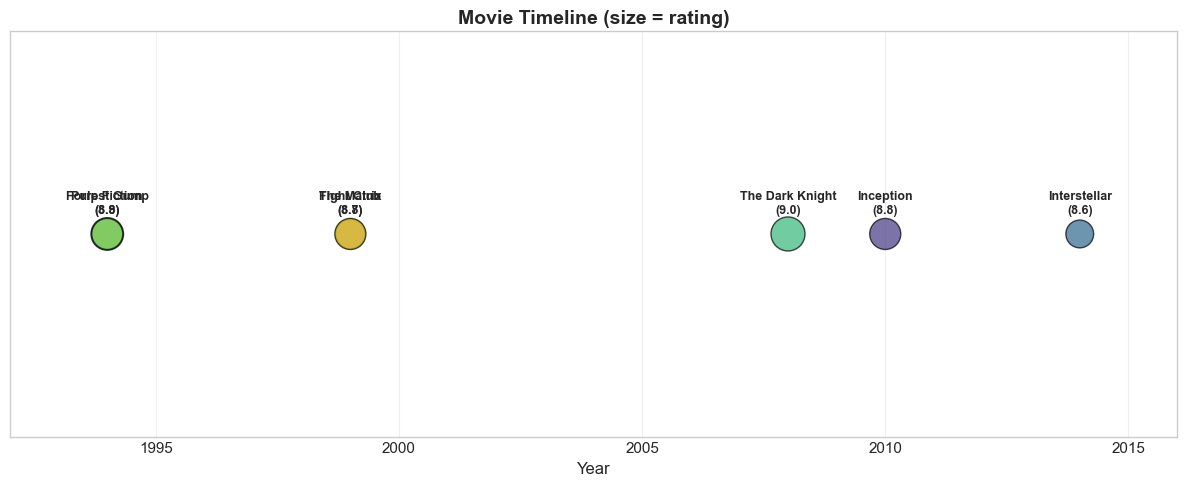

Saved to: output/visualizations/movie_timeline.png


In [26]:
# Timeline visualization
print("\nMovies Over Time")
print("=" * 50)

fig, ax = plt.subplots(figsize=(12, 5))

# Create a timeline
years = df['year'].values
titles = df['title'].values
ratings = df['rating'].values

# Scatter plot with size based on rating
sizes = [(r - 8) * 500 + 100 for r in ratings]  # Scale ratings for visibility
colors = plt.cm.viridis(np.linspace(0, 1, len(years)))

scatter = ax.scatter(years, [1]*len(years), s=sizes, c=colors, alpha=0.7, edgecolors='black')

# Add movie titles
for year, title, rating in zip(years, titles, ratings):
    ax.annotate(f'{title}\n({rating})', (year, 1), 
                textcoords="offset points", xytext=(0, 15),
                ha='center', fontsize=9, fontweight='bold')

ax.set_xlabel('Year', fontsize=12)
ax.set_title('Movie Timeline (size = rating)', fontsize=14, fontweight='bold')
ax.set_yticks([])
ax.set_xlim(df['year'].min() - 2, df['year'].max() + 2)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../output/visualizations/movie_timeline.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved to: output/visualizations/movie_timeline.png")

---

## 10. Cleanup & Summary

Let's clean up our resources and summarize what we've learned.

In [27]:
# Cleanup
print("Cleaning up resources...")

if neo4j_available and neo4j_loader:
    neo4j_loader.close()
    print("   Neo4j connection closed")

print("   RDF graph in memory (no cleanup needed)")
print("\nExploration complete!")

Cleaning up resources...
   RDF graph in memory (no cleanup needed)

Exploration complete!


---

## 📚 Summary: What We Learned

### Key Takeaways

1. **RDF/SPARQL** (Semantic Web)
   - Triple-based data model: Subject → Predicate → Object
   - Standards-compliant (W3C)
   - Good for data integration and reasoning
   - Steeper learning curve but powerful semantics

2. **Neo4j/Cypher** (Property Graph)
   - Intuitive node-relationship model
   - ASCII-art query syntax
   - Excellent performance for traversals
   - Great for recommendations and analytics

3. **When to Use Each**
   - **RDF**: Standards compliance, semantic reasoning, linked data
   - **Neo4j**: Performance-critical, developer productivity, real-time queries

### Generated Visualizations

Check the `output/visualizations/` folder for:
- `genre_distribution.png` - Genre analysis charts
- `director_analysis.png` - Director productivity charts
- `knowledge_graph.png` - Full graph visualization
- `movie_timeline.png` - Temporal visualization
